# Курсовой проект

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/test.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

## EDA

**Класс предобработки данных**

**Устранение выбросов и пропусковх**

In [5]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Класс построения новых признаков

In [6]:
class FeatureGenetator():
    """Генерация новых фич"""

    def floor_to_cat(X):

        X['floor_cat'] = 0

        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5

        return X


    def floor_to_cat_pandas(X):
        bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X


    def year_to_cat(X):

        X['year_cat'] = 0

        X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

        return X


    def year_to_cat_pandas(X):
        bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X    

    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None

    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        self.floor_max = df['Floor'].max()
        self.floor_min = df['Floor'].min()
        self.house_year_max = df['HouseYear'].max()
        self.house_year_min = df['HouseYear'].min()
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)

        if y is not None:
            df['Price'] = y.values
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        #dummies = pd.get_dummies(X, columns=['DistrictId'])
        #X = pd.concat([X, dummies], axis=1)

        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [7]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge'] 

target_name = 'Price'

### Загрузка данных и разбиение на train и test

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]
X_full = pd.concat([X,test_df], ignore_index=True)
X_full.shape

(15000, 19)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [10]:
preprocessor = DataPreprocessing()

# вычисляем на всем пространстве
preprocessor.fit(X_full)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

# все пары имеющие таргетное значение
X_proc =  preprocessor.transform(X)

X_train.shape, X_valid.shape, test_df.shape, X_proc.shape

((6700, 22), (3300, 22), (5000, 22), (10000, 22))

In [11]:
features_gen = FeatureGenetator()

# вычисляем на всем пространстве
features_gen.fit(X_full)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

# все пары имеющие таргетное значение
X_proc =  features_gen.transform(X_proc)

X_train.shape, X_valid.shape , test_df.shape, X_proc.shape

((6700, 27), (3300, 27), (5000, 27), (10000, 27))

In [12]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]
X_proc = X_proc[feature_names + new_feature_names]

In [13]:
# check NA
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum(),X_proc.isna().sum().sum()

(0, 0, 0, 0)

### Построение модели

**Обучение RF**

In [14]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

**Оценка модели RF**

Train R2:	0.961
Test R2:	0.752


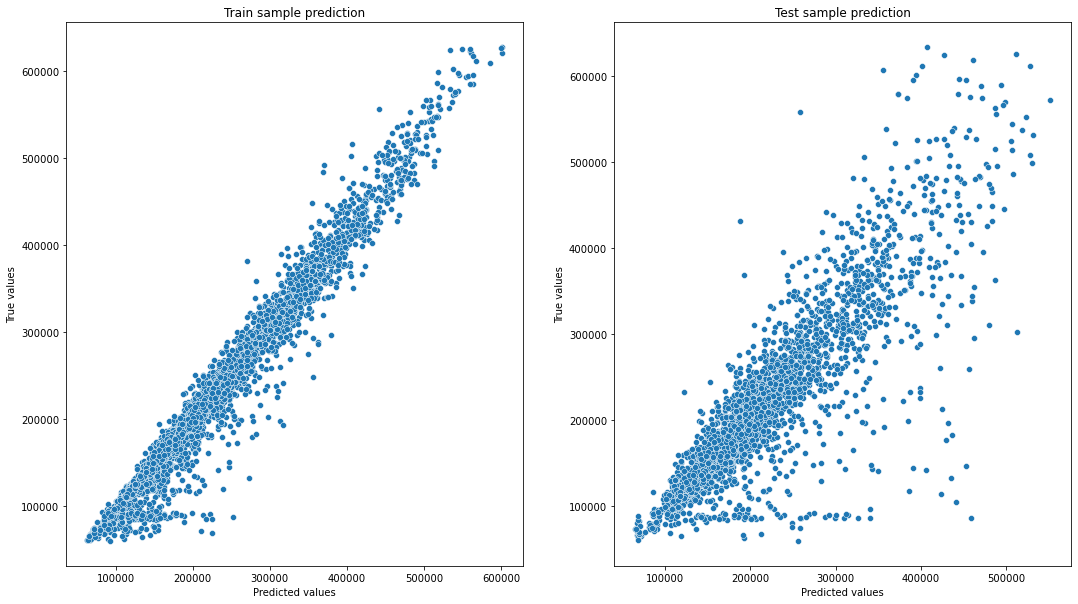

In [15]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация RF**

In [16]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72762861, 0.6741712 , 0.7216245 ])

In [17]:
cv_score.mean()

0.707808101940231

**Важность признаков**

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.432387
20,DistrictSize,0.228460
12,Social_3,0.053268
2,LifeSquare,0.040207
6,HouseYear,0.038260
7,Ecology_1,0.033395
11,Social_2,0.030083
5,HouseFloor,0.024318
4,Floor,0.023729
10,Social_1,0.023034


**Обучение GB/XGB**

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Поиск по сетке
# parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
#                   'subsample'    : [0.9, 0.5, 0.2, 0.1],
#                   'n_estimators' : [100,500,1000, 1500],
#                   'max_depth'    : [4,6,8,10]
#                  }
# grid_GBR = GridSearchCV(estimator=XGBRegressor(), param_grid = parameters, cv = 2, n_jobs=-1)
# grid_GBR.fit(X_train, y_train)
# print(grid_GBR.best_estimator_)
# grid_GBR = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = parameters, cv = 2, n_jobs=-1)
# grid_GBR.fit(X_train, y_train)
# print(grid_GBR.best_estimator_)

In [20]:
xgb = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000,
                          subsample=0.5, random_state=21) # n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
gbm = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000,
                          subsample=0.5, random_state=21)
gbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

**Оценка GB/XGB**

Train R2:	0.886
Test R2:	0.764


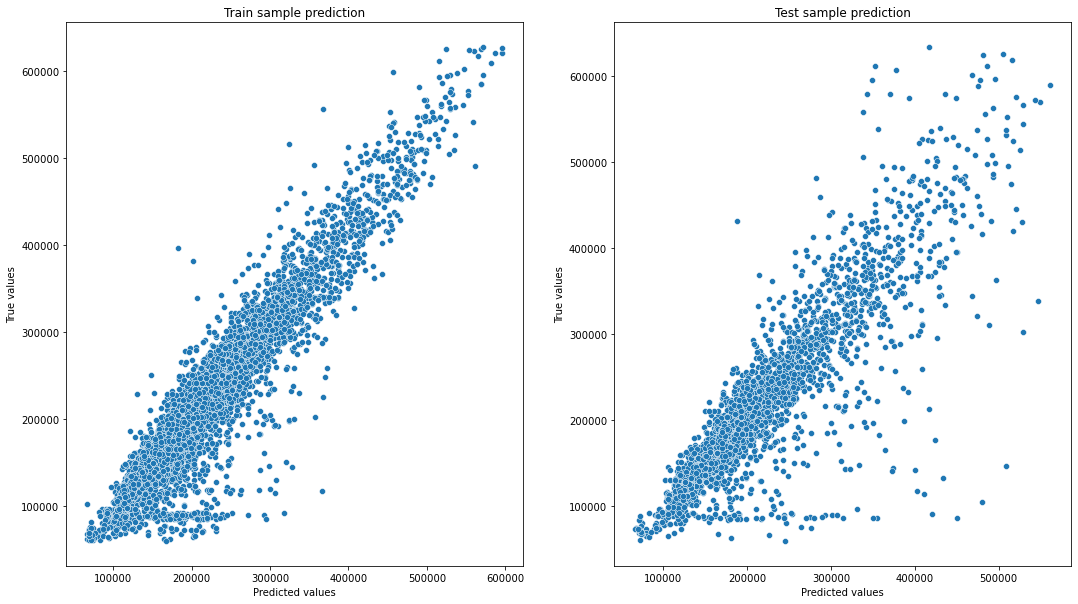

Train R2:	0.899
Test R2:	0.765


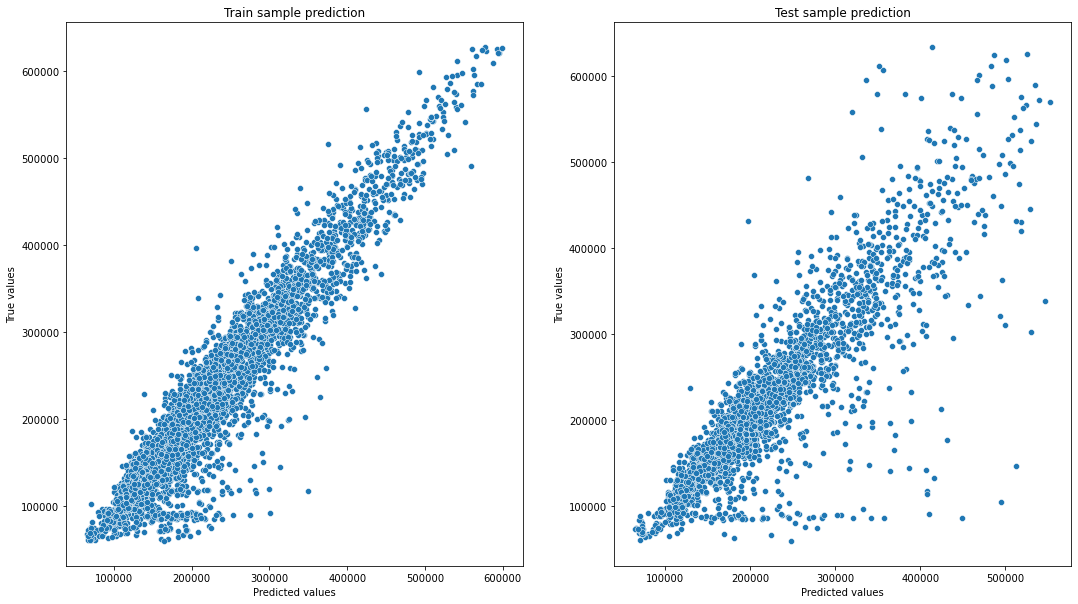

In [21]:
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

y_train_preds_gbr = gbm.predict(X_train)
y_test_preds_gbr = gbm.predict(X_valid)
evaluate_preds(y_train, y_train_preds_gbr, y_valid, y_test_preds_gbr)

**Кросс-валидация GB/XGB**

In [22]:
cv_score = cross_val_score(xgb, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
print(cv_score)
cv_score = cross_val_score(gbm, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
print(cv_score)

[0.74142691 0.70244783 0.73670809]
[0.7412595  0.70040875 0.73494647]


In [23]:
# переобучить на всю выборку
gbm.fit(X_proc, y)

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=1000,
                          random_state=21, subsample=0.5)

**Важность признаков**

In [24]:
feature_importances = pd.DataFrame(zip(X_train.columns, gbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.419299
20,DistrictSize,0.228994
12,Social_3,0.054898
6,HouseYear,0.043366
7,Ecology_1,0.040090
2,LifeSquare,0.036148
11,Social_2,0.035780
5,HouseFloor,0.028543
10,Social_1,0.026020
0,Rooms,0.022359


### Прогнозирование на тестовом датасете

In [25]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [26]:
predictions = gbm.predict(test_df)
predictions

array([163972.53290549, 122557.47420266, 157790.30335327, ...,
       145407.46240144, 194628.12682926, 254382.75161538])

In [27]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163972.532905
1,5925,122557.474203
2,960,157790.303353
3,3848,117362.173263
4,746,207545.857244


In [28]:
submit.to_csv('submission.csv', index=False)